In [241]:
import sys
import os
import grpc

import matplotlib.pyplot as plt
import numpy as np

import kalman.services.kalman_filter_pb2_grpc as api
import kalman.services.kalman_filter_pb2 as api_data

from kalman.data.motion_model_pb2 import MotionModel, MotionModelParameters
from kalman.data.data_pb2 import Measurement, Estimate


measurement_std = 3
measurement_variance = measurement_std ** 2

parameters = MotionModelParameters()
parameters.delta_time = 1
parameters.process_variance_acceleration = 0.04
parameters.system_states = 3
motion_model = MotionModel(motion_model_type=MotionModel.CONSTANT_VELOCITY, motion_model_parameters=parameters)
print(motion_model)


motion_model_parameters {
  delta_time: 1.0
  process_variance_acceleration: 0.03999999910593033
  system_states: 3
}



In [242]:
# Create Kalman Filter for x and y position
with grpc.insecure_channel("0.0.0.0:5000") as channel:
    kalman_stub = api.KalmanFilterRPCStub(channel)
    request = api_data.CreateRequest(identifier="x", motion_model=motion_model, measurement_variance=measurement_variance)
    response = kalman_stub.Create(request)
    print(f"{response}")
    request = api_data.CreateRequest(identifier="y", motion_model=motion_model, measurement_variance=measurement_variance)
    response = kalman_stub.Create(request)
    print(f"{response}")

In [243]:
# Test - Get value from x position: Expected is nothing(=zero) since we have never done a tick.
with grpc.insecure_channel("0.0.0.0:5000") as channel:
    kalman_stub = api.KalmanFilterRPCStub(channel)
    request = api_data.GetRequest(identifier="x")
    response = kalman_stub.Get(request)
    print(f"Response is {response}")

Response is estimate {
}



In [244]:
# Define wrapper function for ticking a kalman filter instance
def tick_kalman_filter(identifier, value):
    with grpc.insecure_channel("0.0.0.0:5000") as channel:
        kalman_stub = api.KalmanFilterRPCStub(channel)
        measurement = Measurement(value=value)
        request = api_data.TickRequest(identifier=identifier, measurement=measurement)
        response = kalman_stub.Tick(request)
        return response.estimate.position

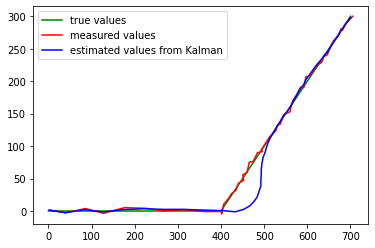

In [245]:
# Play around
# Create true trajectory
true_x_values = np.linspace(0, 400, 10)
true_y_values = np.linspace(0, 0, 10)

true_x_values = np.hstack((true_x_values,np.linspace(400, 700, 40)))
true_y_values = np.hstack((true_y_values,np.linspace(0, 300, 40)))

# Add measurement noise
measured_x_values = true_x_values + np.random.normal(0, measurement_std, true_x_values.size)
measured_y_values = true_y_values + np.random.normal(0, measurement_std, true_y_values.size)

# Use Kalman Filter to get better estimates
kalman_x_values = []
kalman_y_values = []
for x_value, y_value in zip(measured_x_values, measured_y_values):
    kalman_x_values.append(tick_kalman_filter("x", x_value))
    kalman_y_values.append(tick_kalman_filter("y", y_value))

kalman_x_values = np.asarray(kalman_x_values)
kalman_y_values = np.asarray(kalman_y_values)

plt.plot(true_x_values, true_y_values, "g", label="true values")
plt.plot(measured_x_values, measured_y_values, "r", label="measured values")
plt.plot(kalman_x_values, kalman_y_values, "b", label="estimated values from Kalman")

plt.legend()
plt.show()


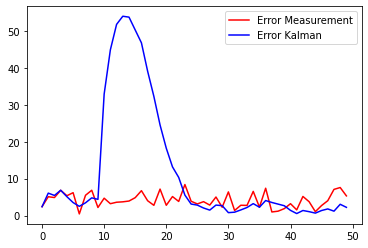

In [246]:
#Investigate error behaviour
error_measurement = np.sqrt((measured_x_values - true_x_values)**2 + (measured_y_values - true_y_values)**2 )
error_kalman = np.sqrt((kalman_x_values - true_x_values)**2 + (kalman_y_values - true_y_values)**2 )
plt.plot(np.arange(0, measured_x_values.size, 1), error_measurement, "r", label="Error Measurement")
plt.plot(np.arange(0, kalman_x_values.size, 1), error_kalman, "b", label="Error Kalman")
plt.legend()
plt.show()
